In [1]:
import pyemma
import pickle
import os
import glob
import torch

import mdtraj as md
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt
import numpy as np

np.bool = np.bool_

from tqdm import tqdm
from matplotlib.colors import LogNorm
from itertools import combinations

blue = (70 / 255, 110 / 255, 250 / 255)
green = (100 / 255, 170 / 255, 120 / 255)

molecule = "CLN025"
simulation_idx = 0
base_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-protein"
save_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein"
pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/notebook/{molecule}_from_mae.pdb"

# Visualization

In [54]:
print(pdb_path)
pdb_traj = md.load_pdb(pdb_path)
print(pdb_traj)
pdb_view = nv.show_mdtraj(pdb_traj)
pdb_view.add_representation("licorice", selection="protein")
pdb_view

/home/shpark/prj-mlcv/lib/DESRES/notebook/2JOF_from_mae.pdb
<mdtraj.Trajectory with 1 frames, 272 atoms, 20 residues, without unitcells>


NGLWidget()

In [55]:
# Count the number of .dcd files in the simulation directory
dcd_pattern = f"{base_dir}/{molecule}-{simulation_idx}-protein-*.dcd"
dcd_files = glob.glob(dcd_pattern)
num_files = len(dcd_files)

print(f"Found {num_files} .dcd files in {base_dir}")
print(f"Pattern used: {dcd_pattern}")

# Extract the indices from filenames and sort them
file_indices = []
for file_path in dcd_files:
    filename = os.path.basename(file_path)
    # Extract the index from filename like "2JOF-0-protein-000.dcd"
    index_part = filename.split('-')[-1].replace('.dcd', '')
    if index_part.isdigit():
        file_indices.append(int(index_part))

file_indices.sort()
print(f"File indices range: {min(file_indices)} to {max(file_indices)}")
print(f"Total files to load: {len(file_indices)}")

Found 105 .dcd files in /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein
Pattern used: /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein-*.dcd
File indices range: 0 to 104
Total files to load: 105


In [58]:
# Load trajectories using the actual file indices found
traj_list = []
for i in tqdm(
    file_indices,
    desc="Loading trajectories"
):
    file_idx = f"{i:03d}"
    file_path = f"{base_dir}/{molecule}-{simulation_idx}-protein-{file_idx}.dcd"
    # print(file_path)
    # Check if file exists before loading
    if os.path.exists(file_path):
        traj = md.load_dcd(file_path, top=pdb_path)
        traj_list.append(traj)
    else:
        print(f"Warning: File not found: {file_path}")

print(f"Successfully loaded {len(traj_list)} trajectory files")
all_traj = md.join(traj_list)

Loading trajectories: 100%|██████████| 105/105 [00:03<00:00, 29.73it/s]


Successfully loaded 105 trajectory files


In [59]:
view = nv.show_mdtraj(all_traj)
view.add_representation("licorice", selection="protein")
view

NGLWidget(max_frame=1043999)

In [40]:
view.frame = 0

In [ ]:
bond_num_distance_angle = torch.load("/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_CLN025-0-protein/CLN025-0-bond_num_distance_angle.pt").numpy()
print(np.where(bond_num_distance_angle == 0)[0])

[     0      1      2 ... 527417 527418 529452]


In [42]:
all_traj[view.frame].save_pdb("folded_0bond.pdb")

In [14]:
pdb_md = md.load_pdb("test.pdb")
pdb_nv = nv.show_mdtraj(pdb_md)
pdb_nv.add_representation("licorice", selection="protein")
pdb_nv

NGLWidget()

# Descriptors

In [72]:
pdb = md.load(pdb_path)
ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(pdb.topology.residues), 2)]
)
ca_pair_contacts, resid_pairs = md.compute_contacts(
	all_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)

print(ca_pair_contacts.shape)
print(ca_pair_contacts.mean())
# NOTE: results are same, but this is faster
ca_pair_contacts = torch.from_numpy(ca_pair_contacts)
torch.save(ca_pair_contacts, f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-CAdistance.pt")

(530000, 45)
0.7388713


In [69]:
ca_idx = pdb.topology.select("name CA")
ca_pairs = np.array(list(combinations(ca_idx, 2)))
ca_pair_distances = md.compute_distances(
	all_traj, atom_pairs = ca_pairs
)

print(ca_pair_distances.shape)
# NOTE: contacts and distances results the same
# ca_pair_distances = torch.from_numpy(ca_pair_distances)
# torch.save(ca_pair_distances, f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-CAdistance.pt")

(530000, 45)


In [74]:
ca_pair_distances_swtich = (1 - np.power(ca_pair_contacts / 0.8, 6)) / (1 - np.power(ca_pair_contacts / 0.8, 12))
print(ca_pair_distances_swtich.shape)
print(ca_pair_distances_swtich.mean())
torch.save(ca_pair_distances_swtich, f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-CAdistance-switch.pt")

/tmp/ipykernel_2447780/3956228591.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ca_pair_distances_swtich = (1 - np.power(ca_pair_contacts / 0.8, 6)) / (1 - np.power(ca_pair_contacts / 0.8, 12))


torch.Size([530000, 45])
tensor(0.6251)


In [39]:
xyz = all_traj.xyz
print(xyz.shape)

torch.save(torch.from_numpy(xyz), f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-pos-nano.pt")

(530000, 166, 3)


# TICA

In [43]:
# TICA with pair distances
for lag in (1, 5, 10, 100):
	data = ca_pair_distances
	tica_obj = pyemma.coordinates.tica(data, lag=lag, dim=2)
	tica_data = tica_obj.get_output()[0]
	x = tica_data[:, 0]
	y = tica_data[:, 1]

	# State information
	# state_traj = md.load(pdb_path)
	# state_ca_pair_contacts, resid_pairs = md.compute_contacts(
	# 	state_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
	# )
	# tica_state = tica_obj.transform(state_ca_pair_contacts)

	# Plot
	fig = plt.figure(figsize=(6, 6))
	ax = fig.add_subplot(111)
	ax.hist2d(x, y, bins=100, norm=LogNorm())
	ax.set_xlabel("TIC 1")
	ax.set_ylabel("TIC 2")
	plt.title(f"TICA with pair distances, lag={lag}")
	plt.savefig(f'../data/{molecule}_tica_model_lag{lag}.png')
	plt.show()
	plt.close()

	with open(f'../data/{molecule}_tica_model_lag{lag}.pkl', 'wb') as f:
		pickle.dump(tica_obj, f)

NameError: name 'ca_pair_distances' is not defined

In [ ]:
# TICA with pair distances switch
for lag in (1, 5, 10, 100):
	data = ca_pair_distances_swtich
	tica_obj = pyemma.coordinates.tica(data, lag=lag, dim=2)
	tica_data = tica_obj.get_output()[0]
	x = tica_data[:, 0]
	y = tica_data[:, 1]

	# State information
	# state_traj = md.load(pdb_path)
	# state_ca_pair_contacts, resid_pairs = md.compute_contacts(
	# 	state_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
	# )
	# state_ca_pair_contacts_switch = (1 - np.power(state_ca_pair_contacts / 0.8, 6)) / (1 - np.power(state_ca_pair_contacts / 0.8, 12))
	# tica_state = tica_obj.transform(state_ca_pair_contacts_switch)

	# Plot
	fig = plt.figure(figsize=(6, 6))
	ax = fig.add_subplot(111)
	ax.hist2d(x, y, bins=100, norm=LogNorm())
	# ax.scatter(tica_state[:, 0], tica_state[:, 1], c='red', s=10)
	ax.set_xlabel("TIC 1")
	ax.set_ylabel("TIC 2")
	plt.title(f"TICA with pair distances switch, lag={lag}")
	plt.savefig(f'../data/{molecule}_tica_model_switch_lag{lag}.png')
	plt.show()
	plt.close()

	with open(f'../data/{molecule}_tica_model_switch_lag{lag}.pkl', 'wb') as f:
		pickle.dump(tica_obj, f)

# State and bonds

## States

In [6]:
def label_by_hbond(
    traj,
    distance_cutoff=0.35,
    angle_cutoff=110,
    bond_number_cutoff=3
):
	"""
	Generate binary labels for folded/unfolded states based at least 3 bonds among eight bonds
	- TYR1T-YR10OT1
	- TYR1T-YR10OT2
	- ASP3N-TYR8O
	- THR6OG1-ASP3O
	- THR6N-ASP3OD1
	- THR6N-ASP3OD2
	- TYR10N-TYR1O


	Args:
		traj (mdtraj): mdtraj trajectory object
		distance_cutoff (float): donor-acceptor distance cutoff in nm (default 0.35 nm = 3.5 amstrong)
		angle_cutoff (float): hydrogen bond angle cutoff in degrees (default 110 deg)
		bond_number_cutoff (int): minimum number of bonds to be considered as folded (default 3)

	Returns:
		labels (np.array): binary array (1: folded, 0: unfolded)
	"""
	# TYR1N-YR10OT1
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	hydrogen_idx, hydrogen_idx, hydrogen_idx_3 = 1, 2, 3   # Tyr10:H
	acceptor_idx = traj.topology.select('residue 10 and name O')[0]   # Tyr10:OT1
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	angle_2 = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	angle_3 = md.compute_angles(traj, [[donor_idx, hydrogen_idx_3, acceptor_idx]]) * (180.0 / np.pi)
	label_O1 = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff) & (angle_2[:,0] > angle_cutoff)).astype(int)
	label_O3 = ((distance[:,0] < distance_cutoff) & (angle_3[:,0] > angle_cutoff)).astype(int)
	label_TYR1N_TYR10OT1 = label_O1 | label_O2 | label_O3


	# TYR1N-YR10OT2
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	hydrogen_idx_1, hydrogen_idx_2, hydrogen_idx_3 = 1, 2, 3   # Tyr10:H
	acceptor_idx = traj.topology.select('residue 10 and name OXT')[0]   # Tyr10:OT2
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle_1 = md.compute_angles(traj, [[donor_idx, hydrogen_idx_1, acceptor_idx]]) * (180.0 / np.pi)
	angle_2 = md.compute_angles(traj, [[donor_idx, hydrogen_idx_2, acceptor_idx]]) * (180.0 / np.pi)
	angle_3 = md.compute_angles(traj, [[donor_idx, hydrogen_idx_3, acceptor_idx]]) * (180.0 / np.pi)
	label_O1 = ((distance[:,0] < distance_cutoff) & (angle_1[:,0] > angle_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff) & (angle_2[:,0] > angle_cutoff)).astype(int)
	label_O3 = ((distance[:,0] < distance_cutoff) & (angle_3[:,0] > angle_cutoff)).astype(int)
	label_TYR1N_TYR10OT2 = label_O1 | label_O2 | label_O3


	# ASP3N-TYR8O
	donor_idx = traj.topology.select('residue 3 and name N')[0]
	hydrogen_idx = 45
	acceptor_idx = traj.topology.select('residue 8 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_ASP3N_TYR8O = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
 
 
	# THR6OG1-ASP3O
	donor_idx = traj.topology.select('residue 6 and name OG1')[0]
	hydrogen_idx = 92
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_THR6OG1_ASP3O = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
 
 
	# THR6N-ASP3OD1
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	hydrogen_idx = 86
	acceptor_idx = traj.topology.select('residue 3 and name OD1')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_THR6N_ASP3OD1 = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
 
	# THR6N-ASP3OD2
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	hydrogen_idx = 86
	acceptor_idx = traj.topology.select('residue 3 and name OD2')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_THR6N_ASP3OD2 = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
 
 
	# GLY7N-ASP3O
	donor_idx = traj.topology.select('residue 7 and name N')[0]
	hydrogen_idx = 100
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_GLY7N_ASP3O = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
 

	# TYR10N-TYR1O
	donor_idx = traj.topology.select('residue 10 and name N')[0] 
	hydrogen_idx = 145
	acceptor_idx = traj.topology.select('residue 1 and name O')[0] 
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_TYR10N_TYR1O = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)




	# ASP3OD_THR6OG1_ASP3N_THR8O
	bond_sum = label_TYR1N_TYR10OT1 + label_TYR1N_TYR10OT2 + labels_ASP3N_TYR8O + labels_THR6OG1_ASP3O \
		+ labels_THR6N_ASP3OD1 + labels_THR6N_ASP3OD2 + labels_GLY7N_ASP3O + labels_TYR10N_TYR1O
	labels = bond_sum >= bond_number_cutoff

	# print(label_TYR10OT_TYR1N.sum())
	# print(labels_TYR10N_TYR1O.sum())
	# print(labels_ASP3OD_THR6OG1.sum())
	# print(labels_ASP3N_TYR8O.sum())

	return labels, bond_sum

def label_by_hbond_distance(
    traj,
    distance_cutoff=0.35,
    bond_number_cutoff=3
):
	"""
	Generate binary labels for folded/unfolded states based at least 3 bonds among eight bonds
	- TYR1T-YR10OT1
	- TYR1T-YR10OT2
	- ASP3N-TYR8O
	- THR6OG1-ASP3O
	- THR6N-ASP3OD1
	- THR6N-ASP3OD2
	- TYR10N-TYR1O


	Args:
		traj (mdtraj): mdtraj trajectory object
		distance_cutoff (float): donor-acceptor distance cutoff in nm (default 0.35 nm = 3.5 amstrong)
		angle_cutoff (float): hydrogen bond angle cutoff in degrees (default 110 deg)
		bond_number_cutoff (int): minimum number of bonds to be considered as folded (default 3)

	Returns:
		labels (np.array): binary array (1: folded, 0: unfolded)
	"""
	# TYR1N-YR10OT1
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	acceptor_idx = traj.topology.select('residue 10 and name O')[0]   # Tyr10:OT1
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_O1 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff)).astype(int) 
	label_O3 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_TYR1N_TYR10OT1 = label_O1 | label_O2 | label_O3


	# TYR1N-YR10OT2
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	acceptor_idx = traj.topology.select('residue 10 and name OXT')[0]   # Tyr10:OT2
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_O1 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O3 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_TYR1N_TYR10OT2 = label_O1 | label_O2 | label_O3


	# ASP3N-TYR8O
	donor_idx = traj.topology.select('residue 3 and name N')[0]
	acceptor_idx = traj.topology.select('residue 8 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_ASP3N_TYR8O = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# THR6OG1-ASP3O
	donor_idx = traj.topology.select('residue 6 and name OG1')[0]
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6OG1_ASP3O = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# THR6N-ASP3OD1
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name OD1')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6N_ASP3OD1 = ((distance[:,0] < distance_cutoff)).astype(int)
 
	# THR6N-ASP3OD2
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name OD2')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6N_ASP3OD2 = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# GLY7N-ASP3O
	donor_idx = traj.topology.select('residue 7 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_GLY7N_ASP3O = ((distance[:,0] < distance_cutoff)).astype(int)
 

	# TYR10N-TYR1O
	donor_idx = traj.topology.select('residue 10 and name N')[0] 
	acceptor_idx = traj.topology.select('residue 1 and name O')[0] 
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_TYR10N_TYR1O = ((distance[:,0] < distance_cutoff)).astype(int)

	# ASP3OD_THR6OG1_ASP3N_THR8O
	bond_sum = label_TYR1N_TYR10OT1 + label_TYR1N_TYR10OT2 + label_ASP3N_TYR8O + label_THR6OG1_ASP3O \
		+ label_THR6N_ASP3OD1 + label_THR6N_ASP3OD2 + label_GLY7N_ASP3O + label_TYR10N_TYR1O
	labels = bond_sum >= bond_number_cutoff

	return labels, bond_sum

In [7]:
label_distance, bond_num_distance = label_by_hbond_distance(all_traj)
print(label_distance.shape)
print(bond_num_distance.shape)

label_distance_angle, bond_num_distance_angle = label_by_hbond(all_traj)
print(label_distance_angle.shape)
print(bond_num_distance_angle.shape)

(530000,)
(530000,)
(530000,)
(530000,)


In [63]:
folded_state_distance = label_distance.sum()
print("Foldedness by H bond distance")
print(f"Folded: {folded_state_distance} / {label_distance.shape[0]} ({folded_state_distance / label_distance.shape[0] * 100:.2f}%)")
print(f"Unfolded: {label_distance.shape[0] - folded_state_distance} / {label_distance.shape[0]} ({(label_distance.shape[0] - folded_state_distance) / label_distance.shape[0] * 100:.2f}%)")

folded_state_distance_angle = label_distance_angle.sum()
print("\nFoldedness by H bond distance and angle")
print(f"Folded: {folded_state_distance_angle} / {label_distance_angle.shape[0]} ({folded_state_distance_angle / label_distance_angle.shape[0] * 100:.2f}%)")
print(f"Unfolded: {label_distance_angle.shape[0] - folded_state_distance_angle} / {label_distance_angle.shape[0]} ({(label_distance_angle.shape[0] - folded_state_distance_angle) / label_distance_angle.shape[0] * 100:.2f}%)")

Foldedness by H bond distance
Folded: 410460 / 530000 (77.45%)
Unfolded: 119540 / 530000 (22.55%)

Foldedness by H bond distance and angle
Folded: 387679 / 530000 (73.15%)
Unfolded: 142321 / 530000 (26.85%)


In [ ]:
# torch.save(torch.from_numpy(label_distance), f"{save_dir}/{molecule}-{simulation_idx}-label_distance.pt")
# torch.save(torch.from_numpy(bond_num_distance), f"{save_dir}/{molecule}-{simulation_idx}-bond_num_distance.pt")
# torch.save(torch.from_numpy(label_distance_angle), f"{save_dir}/{molecule}-{simulation_idx}-label_distance_angle.pt")
# torch.save(torch.from_numpy(bond_num_distance_angle), f"{save_dir}/{molecule}-{simulation_idx}-bond_num_distance_angle.pt")

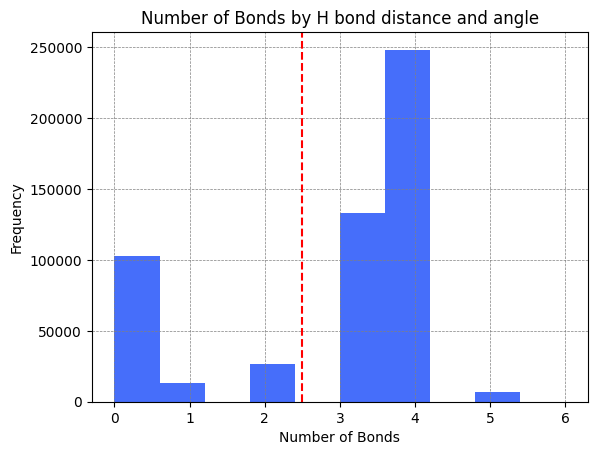

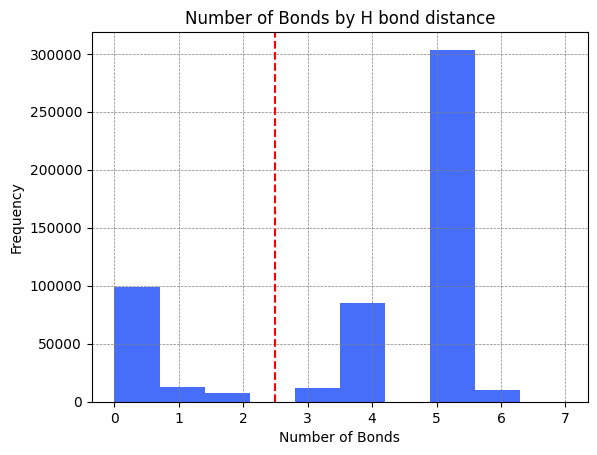

In [88]:
plt.hist(bond_num_distance_angle, color=blue, align='mid')
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both') 
plt.axvline(2.5, color="red", linestyle="--")
plt.xlabel('Number of Bonds')
plt.ylabel('Frequency')
plt.title('Number of Bonds by H bond distance and angle')
plt.savefig(f'{save_dir}/{molecule}-{simulation_idx}-bond_num_distance_angle.png')
plt.show()

plt.hist(bond_num_distance, color=blue, align='mid')
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both') 
plt.axvline(2.5, color="red", linestyle="--")
plt.xlabel('Number of Bonds')
plt.ylabel('Frequency')
plt.title('Number of Bonds by H bond distance')
plt.savefig(f'{save_dir}/{molecule}-{simulation_idx}-bond_num_distance.png')
plt.show()

## Over time

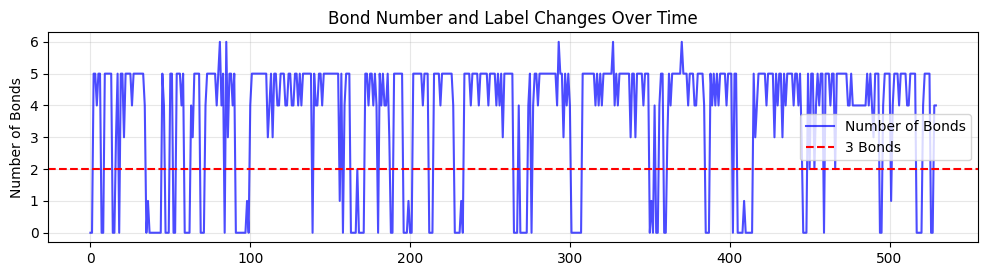

In [68]:
plt.figure(figsize=(12, 6))

# Plot bond_num_array over time
plt.subplot(2, 1, 1)
plt.plot(bond_num_distance[::1000], label='Number of Bonds', color='blue', alpha=0.7)
plt.axhline(y=2, color='red', linestyle='--', label='3 Bonds')
plt.ylabel('Number of Bonds')
plt.title('Bond Number and Label Changes Over Time')
plt.grid(True, alpha=0.3)
plt.legend()


# Time-lag changes